In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [3]:
from tensorflow.keras.utils import to_categorical

In [4]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [5]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 
            'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 
            'CompetitionOpenSinceYear', 'Promo2SinceYear', 
            'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 
            'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 
            'SchoolHoliday_bw']

In [6]:
contin_vars = ['CompetitionDistance', 
               'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 
               'Precipitationmm', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 
               'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 
               'trend_DE', 'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 
               'Promo', 'SchoolHoliday', 'StateHoliday_bool']

In [7]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

# Asignación de dimensión de embeddings

In [8]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 2, 'Year': 2, 'Month': 2,
'Day': 10, 'StateHoliday': 2, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 25, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_bool_fw': 1,
'StateHoliday_bool_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

In [9]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)
    print()

Store 50 1115 [   0    1    2 ... 1112 1113 1114]

DayOfWeek 2 7 [0 1 2 3 4 5 6]

Year 2 3 [0 1 2]

Month 2 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Day 10 31 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]

StateHoliday 2 4 [0 1 2 3]

CompetitionMonthsOpen 2 25 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]

Promo2Weeks 1 26 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]

StoreType 2 4 [0 1 2 3]

Assortment 3 3 [0 1 2]

PromoInterval 3 4 [0 1 2 3]

CompetitionOpenSinceYear 4 21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]

Promo2SinceYear 4 8 [0 1 2 3 4 5 6 7]

State 6 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Week 25 52 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]

Events 4 22 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20

# Definición de modelo

In [10]:
add_customers = True
log_output = False
output_activation = 'linear'

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2

In [12]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

In [13]:
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

In [14]:
first_hidden_units = 400
second_hidden_units = 250
#third_hidden_units = 250
l2_lambda = 1e-3
merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)
x = Dense(first_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(merged)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)
x = Dense(second_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)

#x = Dense(third_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
#x = Activation('relu')(x)


output_1 = Dense(1, name='Sales', activation=output_activation)(x)
output_2 = Dense(1, name='Customers', activation=output_activation)(x)

In [15]:
# from keras.layers import LeakyReLU

# # instead of cnn_model.add(Activation('relu'))
# # use
# cnn_model.add(LeakyReLU(alpha=0.1))

In [16]:
if add_customers:
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1, output_2])
else: 
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1])

In [17]:
model.save_weights('initial_weights.hdf5')

In [18]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


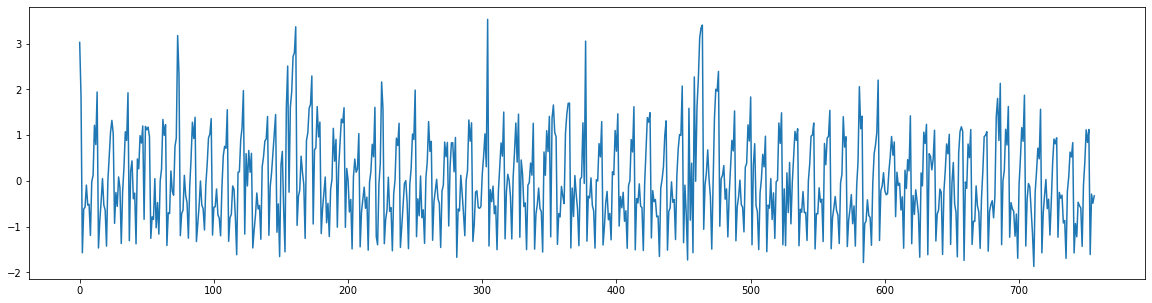

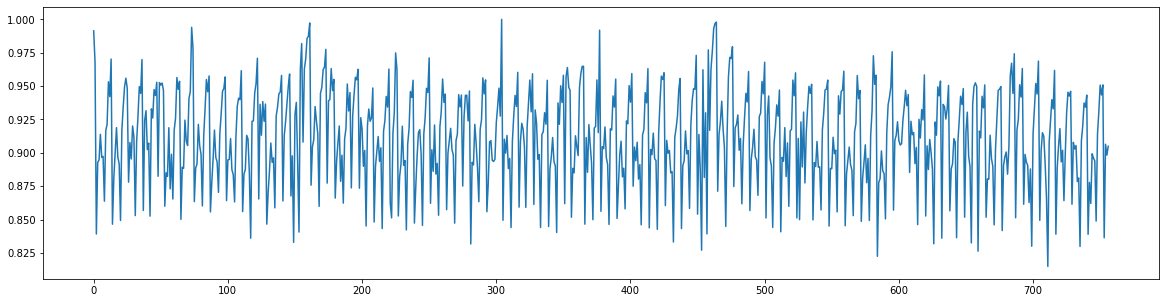

In [19]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,5))
plt.plot((df_train[df_train['Store']==1]['Sales'].values - df_train[df_train['Store']==1]['Sales'].mean())/df_train[df_train['Store']==1]['Sales'].std())
plt.show()
plt.figure(figsize=(20,5))
plt.plot(np.log(df_train[df_train['Store']==1]['Sales'].values)/np.max(np.log(df_train[df_train['Store']==1]['Sales'].values)))
plt.show()

In [20]:
stores_mean = {}
for store, g_df in df_train.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [21]:
df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)

df_train.loc[:, 'Sales_store'] = df_train['Sales'] - df_train['mean_by_store']
df_val.loc[:, 'Sales_store'] = df_val['Sales'] - df_val['mean_by_store']

C:\Users\USUARIO\anaconda3\envs\DeepLeaning38\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\USUARIO\anaconda3\envs\DeepLeaning38\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [22]:
from tensorflow.keras import backend as K

In [23]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

In [24]:
def get_metric(df, sales_):
    return np.sqrt((((df['Sales'] - sales_)/df['Sales'])**2).mean())

In [25]:
get_metric(df_val, df_val['mean_by_store'])

0.3071746085338871

In [26]:
all_vars = cat_vars + contin_vars
X_train = np.hsplit(df_train[all_vars].values, len(all_vars))
X_val = np.hsplit(df_val[all_vars].values, len(all_vars))
X_test = np.hsplit(df_test[all_vars].values, len(all_vars))

In [27]:
if add_customers:
    y_out_columns = ['Sales', 'Customers']
else:
    y_out_columns = ['Sales_store']
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
#     y_mean = df_train[y_out_columns].mean().values
#     y_std = df_train[y_out_columns].std().values
#     y_train = (df_train[y_out_columns].values - y_mean)/y_std
#     y_val = (df_val[y_out_columns].values - y_mean)/y_std
    y_max = df_train[y_out_columns].max().values
    y_train = df_train[y_out_columns].values/y_max
    y_val = df_val[y_out_columns].values/y_max
y_train = np.hsplit(y_train, y_train.shape[1])
y_val = np.hsplit(y_val, y_val.shape[1])

In [28]:
lr = 0.001
model.compile(optimizer=Adam(lr=lr), metrics=['mse', rmspe], loss='mse')

In [29]:
if add_customers:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_Sales_mse', verbose=1, save_best_only=True)
else:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [30]:
epochs = 400 #1000 #100 
batch_size = 4096 #2048 #1024 #256  
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], verbose=2)

Epoch 1/400
199/199 - 17s - loss: 0.0364 - Sales_loss: 0.0028 - Customers_loss: 0.0015 - Sales_mse: 0.0028 - Sales_rmspe: 0.3741 - Customers_mse: 0.0015 - Customers_rmspe: 0.3817 - val_loss: 0.0042 - val_Sales_loss: 0.0011 - val_Customers_loss: 6.5861e-04 - val_Sales_mse: 0.0011 - val_Sales_rmspe: 0.2565 - val_Customers_mse: 6.5861e-04 - val_Customers_rmspe: 0.2830

Epoch 00001: val_Sales_mse improved from inf to 0.00114, saving model to bestmodel.hdf5
Epoch 2/400
199/199 - 11s - loss: 0.0025 - Sales_loss: 9.9166e-04 - Customers_loss: 4.1483e-04 - Sales_mse: 9.9166e-04 - Sales_rmspe: 0.2626 - Customers_mse: 4.1483e-04 - Customers_rmspe: 0.2520 - val_loss: 0.0020 - val_Sales_loss: 9.3619e-04 - val_Customers_loss: 4.0736e-04 - val_Sales_mse: 9.3619e-04 - val_Sales_rmspe: 0.2268 - val_Customers_mse: 4.0736e-04 - val_Customers_rmspe: 0.2382

Epoch 00002: val_Sales_mse improved from 0.00114 to 0.00094, saving model to bestmodel.hdf5
Epoch 3/400
199/199 - 12s - loss: 0.0018 - Sales_loss: 9.2

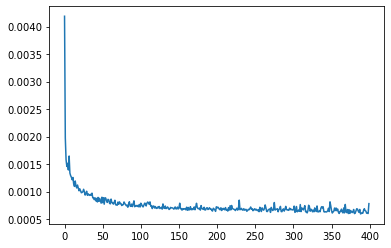

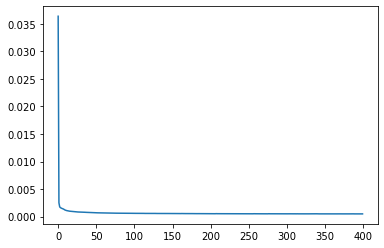

In [31]:
plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_Customers_mse'])
# plt.plot(history.history['val_Sales_mse'])
plt.show()
plt.plot(history.history['loss'])
# plt.plot(history.history['Customers_mse'])
# plt.plot(history.history['Sales_mse'])

# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [32]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 4s 4ms/step - loss: 7.7983e-04 - Sales_loss: 5.4867e-04 - Customers_loss: 1.5217e-04 - Sales_mse: 5.4867e-04 - Sales_rmspe: 0.1562 - Customers_mse: 1.5217e-04 - Customers_rmspe: 0.1306


[0.0007798298029229045,
 0.0005486704758368433,
 0.00015216527390293777,
 0.0005486704758368433,
 0.15621620416641235,
 0.00015216527390293777,
 0.13064461946487427]

In [33]:
model.load_weights('bestmodel.hdf5')
model.evaluate(X_val, y_val)

944/944 [==============================] - 4s 4ms/step - loss: 6.1107e-04 - Sales_loss: 3.9565e-04 - Customers_loss: 1.3268e-04 - Sales_mse: 3.9565e-04 - Sales_rmspe: 0.1137 - Customers_mse: 1.3268e-04 - Customers_rmspe: 0.1087


[0.0006110661197453737,
 0.0003956454456783831,
 0.00013268193288240582,
 0.0003956454456783831,
 0.11368805915117264,
 0.00013268193288240582,
 0.10872362554073334]

In [35]:
if log_output:
    if add_customers:
        y_pred = np.exp(model.predict(X_val, verbose=1)[0][:, 0]*max_log_y[0])
        y_pred_test = np.exp(model.predict(X_test, verbose=1)[0][:, 0]*max_log_y[0])
    else:
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)[:,0]
        y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)[:,0]
else:
    if add_customers:
#         y_pred = (model.predict(X_val, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
#         y_pred_test = (model.predict(X_test, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
        y_pred = (model.predict(X_val, verbose=1)[0]*y_max[0])[:,0]        #?
        y_pred_test = (model.predict(X_test, verbose=1)[0]*y_max[0])[:,0]  #?  
        
    else:
#       y_pred = model.predict(X_val, verbose=1)[:,0]*(y_std + y_mean)
#       y_pred_test = model.predict(X_test, verbose=1)[:,0]*(y_std + y_mean)
        y_pred = model.predict(X_val, verbose=1)[:,0]*y_max
        y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_max
y_pred_test[df_test['Open'] == 0] = 0

1284/1284 [==============================] - 6s 4ms/step


In [36]:
np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))

0.12070851433498171

In [37]:
y_pred_test[:10]

array([4569.8154, 7177.6562, 9181.665 , 6502.5054, 7128.631 , 5872.6987,
       7655.2007, 7947.051 , 4754.418 , 5596.685 ], dtype=float32)

# Sumbit a la competición

In [38]:
sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()
sample_csv.to_csv(f'submision.csv', index=False)
sample_csv.to_csv(f'submision_{add_customers}-{log_output}-{output_activation}-{l2_lambda}-{first_hidden_units}-{epochs}-{batch_size}-{lr}.csv', index=False)


In [39]:
!kaggle competitions submit -c rossmann-store-sales -f submision.csv -m "Message"

Successfully submitted to Rossmann Store Sales


  0%|          | 0.00/618k [00:00<?, ?B/s]
  1%|1         | 8.00k/618k [00:00<00:20, 31.2kB/s]
 16%|#5        | 96.0k/618k [00:00<00:01, 309kB/s] 
 26%|##5       | 160k/618k [00:00<00:01, 375kB/s] 
 43%|####2     | 264k/618k [00:00<00:00, 517kB/s]
 75%|#######5  | 464k/618k [00:00<00:00, 905kB/s]
 93%|#########3| 576k/618k [00:00<00:00, 962kB/s]
100%|##########| 618k/618k [00:03<00:00, 162kB/s]
